# Framing the problem



***how can the predictive model be used to improve business performance?***
---

>After some research some of the usecases of predictive modeling are:



| Usecase                                 	| Bussiness improvement                                                 	|
|-----------------------------------------	|-----------------------------------------------------------------------	|
| Predict customers’ behavior (churn/CLV) 	| Improves retention by targeting the right message to the right users  	|
| Lead scoring                            	| Improves the ROI of activation campaings                              	|
| Recommendation                          	| Improves ARPU  by upsell and cross-sell                               	|
| Personalisation                         	| Improves retention by a better experience                             	|
| Customer segmentation                   	| Improves the ROI of retention campaings                               	|
| Chatbots                                	| Reduces Customer experience costs                                     	|

<br>

[Source 1](https://medium.com/activewizards-machine-learning-company/top-8-data-science-use-cases-in-marketing-d62291ce62b6)

[Source 2](https://www.proxzar.ai/blog/top-8-use-cases-for-machine-learning-ai-in-marketing/)

<br>

---
<br>

> As suggested, the scope will be on the first case: *Predict customers’ behavior (churn/CLV)*

<br>

Having the scope defined, a more in depth research reveals:

**Bussiness benefits**
<br>

 - It allows marketers to prioritize aquisition efforts
 - Maximize the value of top customers
 - Develop a more customer-centric marketing strategy
 - Improve bidding of ad impressions


<br><br>




**Most common approach**
<br>
- This is a non-contractual and comtinuous purchases setting
- FRM features
- Beta Geometric/Negative Binomial Distribution Model combined with the Gamma-Gamma model
- There is a useful package called *lifetimes*

[Source 1](https://towardsdatascience.com/buy-til-you-die-predict-customer-lifetime-value-in-python-9701bfd4ddc0)

[Source 2](https://eng.amperity.com/posts/2019/12/predictive-clv)

[Source 3 - video](https://www.youtube.com/watch?v=gx6oHqpRgpY&ab_channel=PyData)

<br><br>
**Alternative approach**
<br>

- Deep learning with a custom loss function (ZILN Loss)

[Source 1](https://towardsdatascience.com/the-paper-a-deep-probabilistic-model-for-customer-lifetime-value-prediction-eb5d61a83ecd)

[Source 2](https://arxiv.org/pdf/1912.07753.pdf)













# Imports

In [1]:
#installs
!pip install lifetimes --quiet
!pip install imbalanced-learn --quiet
!pip install pycaret[full] --quiet
!pip install gdown --quiet

# imports
from datetime import timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.cluster import KMeans
from sklearn import model_selection
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path


from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity



#set up
pd.options.display.float_format = '{:,.2f}'.format

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.3 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.1 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.2 which is incompatible.
featuretools 1.4.1 requires numpy>=1.21.0, but you have numpy 1.20.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyte

# Get the data

In [2]:
#package all into a function


def get_data(file_id):
    import gdown
    url = f'https://drive.google.com/uc?id={file_id}'
    zip_file = 'data.zip'
    gdown.download(url, zip_file, quiet=False)

    import  gzip


    import  zipfile
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall('unzipped_data')


    users_raw = pd.read_csv('unzipped_data/nsds_users.csv')
    purchases_raw = pd.read_csv('unzipped_data/nsds_purchases.csv')

    return purchases_raw, users_raw

In [3]:
purchases_raw, users_raw = get_data('1TwngwmdW1qMmRvZOYrWf2bXSP40CSJC_')

Downloading...
From: https://drive.google.com/uc?id=1TwngwmdW1qMmRvZOYrWf2bXSP40CSJC_
To: /kaggle/working/data.zip
100%|██████████| 10.8M/10.8M [00:00<00:00, 127MB/s]


# Pre-process


The model will predict the revenue per user of the next 90 days. <br>
In order to train the model we will take the last 90 days of the purchases table and convert that data to the variable we are going to predict : 
<br>





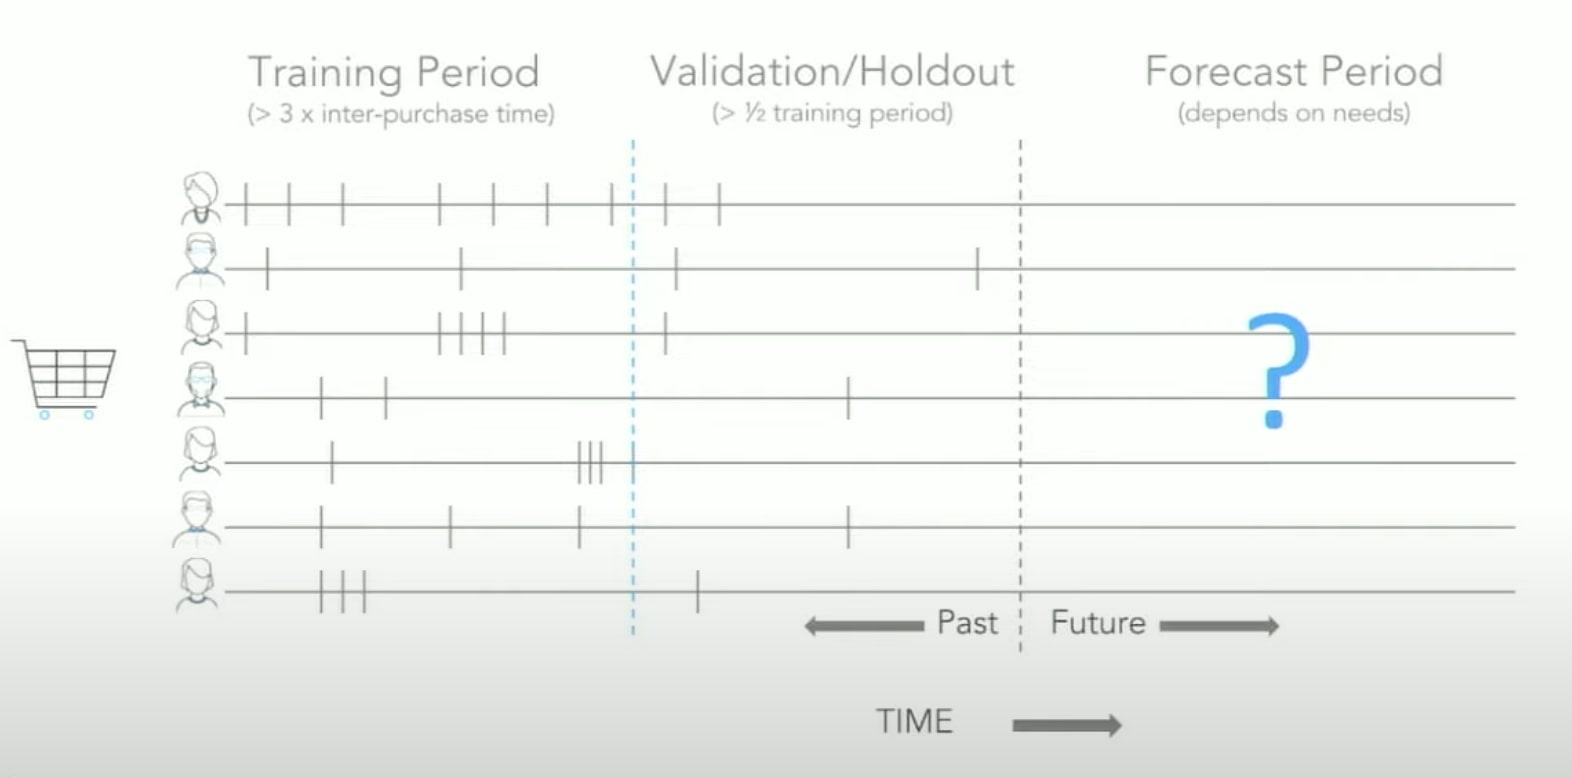

https://youtu.be/gx6oHqpRgpY?t=1046

In [26]:
#split the purchases table
purchase_date = pd.to_datetime(purchases_raw.purchased_at).dt.date
created_date = pd.to_datetime(users_raw.created_at).dt.date

validation_from_date = purchase_date.max() - timedelta(days=90)

X_purchases_raw = purchases_raw[purchase_date <  validation_from_date]
Y_purchases_raw = purchases_raw[purchase_date >= validation_from_date]

X_users_raw = users_raw[created_date <  validation_from_date]

In [5]:

class DataframeFunctionTransformer():
    """Creates a pandas Dataframe transformer from a function"""
    def __init__(self, func, **func_params):
        self.func = func
        self.func_params = func_params

    def transform(self, input_df, **transform_params):
        return self.func(input_df.copy(), **self.func_params)

    def fit(self, X, y=None, **fit_params):
        return self

In [6]:
def select_columns_(df, cols=None):
    return df[cols]

def timify_(df, cols):
    for c in cols: df[c]= pd.to_datetime(df[c])
    return df

def add_date_(df, cols):
    for c in cols: df[f'{c}_date']= pd.to_datetime(df[c]).dt.date
    return df

def categorify_(df, cols):
    for c in cols: df[c]= df[c].astype('object')
    return df

def purchases_to_rfm_(df):
    """
    wrapper to the function summary_data_from_transaction_data
    https://github.com/CamDavidsonPilon/lifetimes/blob/0a0a84fe4b10fff0bdaa6a6020d930c8dc6aee2d/lifetimes/utils.py#L230
    """
    from lifetimes.utils import  summary_data_from_transaction_data
    data = summary_data_from_transaction_data(
                                transactions = df, 
                                customer_id_col = "user_id", 
                                datetime_col = "purchased_at_date",
                                monetary_value_col = "value", 
                                freq = "D").reset_index()
    return data
                                


In [7]:
class FramesLeftMerger(BaseEstimator,TransformerMixin):
    def __init__(self, pipe1, pipe2):
        self.pipe1 = pipe1
        self.pipe2 = pipe2

    def fit(self,X,y=None):
        return self

    def transform(self,X,y=None):
        df1, df2 = X[0], X[1]
        df1 = self.pipe1.transform(df1.copy())
        df2 = self.pipe2.transform(df2.copy())
        merge = df1.merge(df2, how='left', on='user_id')
        merge[df2.columns] = merge[df2.columns].fillna(0)
        return merge

In [8]:
preprocess_purchases = Pipeline(
    steps=[
        ("timify", DataframeFunctionTransformer(timify_ , cols=['purchased_at'])),
        ("add_date", DataframeFunctionTransformer(add_date_ , cols=['purchased_at'])),
        ("rfm", DataframeFunctionTransformer(purchases_to_rfm_)),
    ]
)


users_num_features = ['birthyear', 'dx_0', 'dx_1', 'dx_2', 'dx_3', 'gx', 'im']
users_cat_features = ['gender', 'maildomain', 'region', 'orig_1', 'orig_2', 'utm_src', 'utm_med', 'utm_cpg', 'channel']
select_cols = ['user_id', 'created_at'] + users_cat_features + users_num_features


preprocess_users = Pipeline(
    steps=[
        ("select_cols", DataframeFunctionTransformer(select_columns_ , cols=select_cols)),
        ("timify", DataframeFunctionTransformer(timify_ , cols=['created_at'])),
        ("categorify",DataframeFunctionTransformer(categorify_ , cols=users_cat_features))
    ]
)

full_preprocess = FramesLeftMerger(preprocess_users, preprocess_purchases)

In [27]:
X = full_preprocess.transform((X_users_raw, X_purchases_raw))
X

,user_id,created_at,gender,maildomain,region,orig_1,orig_2,utm_src,utm_med,utm_cpg,...,dx_0,dx_1,dx_2,dx_3,gx,im,frequency,recency,T,monetary_value
0,22451,2019-10-15 11:02:15,NaN,2354,96.00,30.00,NaN,151.00,7.00,"3,434.00",...,46.66,3.19,43.61,62.83,15.89,0.00,2.00,283.00,575.00,0.41
1,11078,2019-03-13 14:38:14,NaN,1787,96.00,75.00,NaN,122.00,14.00,NaN,...,58.81,6.39,54.26,32.17,-20.70,0.00,3.00,745.00,791.00,0.94
2,11790,2019-04-14 01:19:12,NaN,4712,312.00,30.00,NaN,151.00,7.00,"3,203.00",...,44.30,2.16,39.94,48.34,39.09,0.00,0.00,0.00,759.00,0.00
3,90734,2021-05-11 01:29:41,NaN,1787,317.00,39.00,"2,583.00",151.00,7.00,"3,203.00",...,36.87,8.51,38.41,23.80,31.16,0.75,0.00,0.00,0.00,0.00
4,36863,2020-02-22 17:56:22,NaN,1787,15.00,121.00,NaN,160.00,7.00,NaN,...,46.33,10.01,47.88,77.72,-52.07,0.00,0.00,0.00,441.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89727,71908,2020-11-29 02:14:05,NaN,2038,15.00,6.00,NaN,NaN,NaN,NaN,...,43.03,4.44,67.38,55.41,-27.30,0.63,0.00,0.00,0.00,0.00
89728,21371,2019-10-07 12:10:55,NaN,2038,214.00,30.00,NaN,151.00,7.00,"3,203.00",...,60.16,9.41,46.00,49.11,-45.21,0.08,0.00,0.00,0.00,0.00
89729,47087,2020-06-01 07:32:05,NaN,2101,9.00,79.00,NaN,151.00,7.00,"3,213.00",...,64.29,0.07,33.95,55.61,15.36,1.00,1.00,233.00,345.00,0.46
89730,85011,2021-02-28 06:06:47,NaN,3476,319.00,6.00,NaN,NaN,NaN,NaN,...,57.52,10.27,35.60,47.79,-52.10,1.00,0.00,0.00,73.00,0.00


In [28]:
train_full = Y_purchases_raw.groupby('user_id').agg(value_90=('value', 'sum'), purchases_90=('value', 'count')).reset_index()
train_full = X.merge(train_full, how='left', on='user_id')

bins = 4
train_full['value_90_bin'] = pd.qcut(train_full.value_90, bins, labels = [f'bin-{i+1}' for i in range(bins)])
train_full['value_90_bin'] = train_full['value_90_bin'].cat.add_categories('bin-0').fillna('bin-0')
train_full[['value_90', 'purchases_90']] = train_full[['value_90', 'purchases_90']].fillna(0)
train_full['purchases_90_bool'] = train_full['purchases_90']>0
train_full


,user_id,created_at,gender,maildomain,region,orig_1,orig_2,utm_src,utm_med,utm_cpg,...,gx,im,frequency,recency,T,monetary_value,value_90,purchases_90,value_90_bin,purchases_90_bool
0,22451,2019-10-15 11:02:15,NaN,2354,96.00,30.00,NaN,151.00,7.00,"3,434.00",...,15.89,0.00,2.00,283.00,575.00,0.41,0.00,0.00,bin-0,False
1,11078,2019-03-13 14:38:14,NaN,1787,96.00,75.00,NaN,122.00,14.00,NaN,...,-20.70,0.00,3.00,745.00,791.00,0.94,0.48,1.00,bin-2,True
2,11790,2019-04-14 01:19:12,NaN,4712,312.00,30.00,NaN,151.00,7.00,"3,203.00",...,39.09,0.00,0.00,0.00,759.00,0.00,0.00,0.00,bin-0,False
3,90734,2021-05-11 01:29:41,NaN,1787,317.00,39.00,"2,583.00",151.00,7.00,"3,203.00",...,31.16,0.75,0.00,0.00,0.00,0.00,0.00,0.00,bin-0,False
4,36863,2020-02-22 17:56:22,NaN,1787,15.00,121.00,NaN,160.00,7.00,NaN,...,-52.07,0.00,0.00,0.00,441.00,0.00,0.00,0.00,bin-0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89727,71908,2020-11-29 02:14:05,NaN,2038,15.00,6.00,NaN,NaN,NaN,NaN,...,-27.30,0.63,0.00,0.00,0.00,0.00,0.00,0.00,bin-0,False
89728,21371,2019-10-07 12:10:55,NaN,2038,214.00,30.00,NaN,151.00,7.00,"3,203.00",...,-45.21,0.08,0.00,0.00,0.00,0.00,0.00,0.00,bin-0,False
89729,47087,2020-06-01 07:32:05,NaN,2101,9.00,79.00,NaN,151.00,7.00,"3,213.00",...,15.36,1.00,1.00,233.00,345.00,0.46,0.00,0.00,bin-0,False
89730,85011,2021-02-28 06:06:47,NaN,3476,319.00,6.00,NaN,NaN,NaN,NaN,...,-52.10,1.00,0.00,0.00,73.00,0.00,0.00,0.00,bin-0,False


# EDA

## Purchases

In [ ]:
purchases_raw.info()

In [ ]:
purchases_raw.head()

In [ ]:
purchases = DataframeFunctionTransformer(timify_ , cols=['purchased_at']).transform(purchases_raw)
purchases['purchase_date'] = purchases.purchased_at.dt.date

In [ ]:
purchases.user_id.nunique()

In [ ]:
plot_df = purchases.groupby(['user_id']).agg(purchases=('user_id', 'count')).reset_index()

fig = px.histogram(plot_df, x='purchases', title='purchases by user')
fig.show()

fig = px.box(plot_df, x='purchases', title='purchases by user')
fig.show()

In [ ]:
purchases.value.hist()

In [ ]:
plot_df = (purchases.groupby('user_id').agg(purchases=('user_id', 'count')).value_counts()).reset_index().rename(columns={0:'users'})
plot_df['agg_percent_users'] = plot_df.users.sort_values(ascending=False).cumsum()/purchases.user_id.nunique()
fig = px.bar(plot_df, x='purchases', y='agg_percent_users')
fig.update_layout(title_text='% or users vs number of purchases',
                  yaxis_title="agg_percent_users")

In [ ]:
purchases

purchases by date

In [ ]:
plot_df = purchases.groupby(['purchase_date']).agg(purchases=('user_id', 'count'))
fig = px.line(plot_df)
fig.update_layout(title_text='purchases by date',
                  yaxis_title="Sales")
fig.show()
print("Dates with peaks: (there is a peak in the last day of feb that falls into different dates)")
plot_df[plot_df.purchases>300].reset_index().purchase_date.pipe(pd.to_datetime).dt.strftime('%d/%m').value_counts()

In [ ]:
plot_df = purchases.groupby(['purchase_date', 'product', 'product2']).agg(purchases=('user_id', 'count')).reset_index()
fig = px.line(plot_df, x='purchase_date', y='purchases', facet_row='product', facet_col='product2' )
fig.update_layout(title_text='purchases by date',
                  yaxis_title="purchases")
fig.show()


In [ ]:
plot_df = purchases.groupby(['purchase_date', 'product', 'product2']).agg(mean_value=('value', 'mean')).reset_index()
fig = px.line(plot_df, x='purchase_date', y='mean_value', facet_row='product', facet_col='product2' )
fig.update_layout(title_text='mean_value by date',
                  yaxis_title="mean_value")
fig.show()

print(" The peack in sales of the 08/10 was because of a marketing action. Could be useful to meassure price elasticity")

In [ ]:
plot_df = purchases.groupby(['product', 'product2']).agg(purchases=('user_id', 'count')).reset_index()

plot_df['prod'] = plot_df['product'].astype(str).str.cat(plot_df['product2'].astype(str), sep='-')
fig = px.pie(plot_df, values='purchases', names='prod' , title='purchase share by product')
fig.show()

In [ ]:
plot_df = purchases.groupby(['user_id', 'purchase_date']).agg(purchases=('user_id', 'count')).reset_index()
plot_df['agg_purchases'] = plot_df.groupby('user_id')['purchases'].cumsum().reset_index(level=0, drop=True)
plot_df = plot_df.pivot(index='user_id', columns='purchase_date', values='agg_purchases')

plot_df = plot_df.loc[:,plot_df.columns>pd.to_datetime('2021-01-01')]
plot_df = plot_df.loc[plot_df.notna().any(axis=1),:]

fig = px.imshow(plot_df,  color_continuous_scale='Bluered')
fig.show()

## Users

In [ ]:
users_raw.info()

There are more columns than the documentation. In particular: feature,  month,bd_delta,  purchase_90_n, purchase_90_bin, x, intramonth, temp

I will stick to the columns in the documentation for now.<br>
And later include them as an alternative.
As a hypo purchase_90_n could be the purchases in a period outside the available data. (will deal with it in the end)

In [ ]:
users_raw.columns

In [ ]:
users_num_features = ['birthyear', 'dx_0', 'dx_1', 'dx_2', 'dx_3', 'gx', 'im']
users_cat_features = ['gender', 'maildomain', 'region', 'orig_1', 'orig_2', 'utm_src', 'utm_med', 'utm_cpg', 'channel']
#we will not take is_active to train the model as it may have information of the value that is being predicted

users = users_raw[['user_id', 'created_at'] + users_cat_features + users_num_features]

users = DataframeFunctionTransformer(timify_ , cols=['created_at']).transform(users)
users = DataframeFunctionTransformer(categorify_ , cols=users_cat_features).transform(users)

In [ ]:
users.head()

In [ ]:
users = users.merge(rfm, how='left', on='user_id')

users = users.merge(y, how='left', on='user_id')
users[['value_90', 'purchases_90', 'frequency',	'recency',	'T',	'monetary_value']] = users[['value_90', 'purchases_90', 'frequency',	'recency',	'T',	'monetary_value']].fillna(0)

users

In [ ]:
users['value_90_bin'] = pd.qcut(users.value_90.replace(to_replace=0, value=np.nan), 4, labels = ['Q1','Q2', 'Q3', 'Q4'])
users['value_90_bin'] = users['value_90_bin'].cat.add_categories('zero').fillna('zero')

In [ ]:
users.groupby('value_90_bin').user_id.count()

In [ ]:
# no duplicated user_id
users.duplicated(subset='user_id').sum()

In [ ]:
# 100K users
users.shape

In [ ]:
# Checking null values
plot_df = users.isna().mean()

fig = px.bar(plot_df, text_auto=True)
fig.update_layout(title_text='Percentage of nulls', yaxis=dict(tickformat=".2%"))
fig.show()

print("""
Gender feature is 94% empty
""")


In [ ]:
users.corr()['purchases_90']

In [ ]:
fig = px.scatter_matrix(users[['frequency',	'recency',	'T',	'monetary_value','value_90_bin']],
                        dimensions=['frequency',	'recency',	'T',	'monetary_value'],
                        color='value_90_bin' ,width=1200, height=800, opacity=0.6)
fig.show()

Recency: the number of time periods between a customer’s first and last (latest) transactions <br>
Frequency: the number of time periods, after the initial purchase, when the customer buys again<br>
Monetary Value: the average value of the customer’s transactions (revenues or profit per transaction)<br>

Customer age T: the number of time periods since the customer’s first purchase

In [ ]:
# Cohorts volumes

plot_df = users.groupby(users.created_at.dt.strftime('%Y-%m'))[['user_id']].count()

fig = px.bar(plot_df, text_auto=True)
fig.update_layout(title_text='Users by cohort month',
                  yaxis_title="Users",)
fig.show()

print("""
Huge growth on September 2019
Spike in Jul 2020
Some users are created in 2030
""")


In [ ]:
users[users.created_at>pd.to_datetime('2021-09-01')]

In [ ]:
### add to pipeline
users['created_at'] = pd.to_datetime(np.where(users.created_at>pd.Timestamp.today(), pd.NaT, users.created_at))

In [ ]:
plot_df = users.groupby(users.created_at.dt.strftime('%Y-%m'))[['user_id']].count()

fig = px.bar(plot_df.fillna('2016-05'), text_auto=True)
fig.update_layout(title_text='Users by cohort month',
                  yaxis_title="Users",)
fig.show()

In [ ]:
# birthyear distribution

plot_df = users.groupby('birthyear')[['user_id']].count()
fig = px.bar(plot_df, text_auto=True)
fig.update_layout(title_text='Users by birthyear',
                  yaxis_title="Users",)
fig.show()

print("""
Birth year is quite dirty
""")

In [ ]:
### add to pipeline
users['birthyear'] = np.where(users.birthyear.between(pd.Timestamp.today().year - 90, pd.Timestamp.today().year - 15), users.birthyear, np.nan )

In [ ]:
plot_df = users.groupby('birthyear')[['user_id']].count()

fig = px.bar(plot_df, text_auto=True)
fig.update_layout(title_text='Users by birthyear',
                  yaxis_title="Users",)
fig.show()

In [ ]:
# maildomain distribution

plot_df = (users.maildomain.value_counts().cumsum()\
          /users.maildomain.value_counts().sum()).reset_index()

fig = px.line(plot_df, y='maildomain')
fig.update_layout(title_text='Acumulated users by distinct maildomain',
                  yaxis_title="% of Users")
fig.show()


print("""
The first 7 domains cover the 80% of the users
and the first 36 cover the 90% of the users
""")


In [ ]:
### to pipeline
#top10_maildomains = list(users.maildomain.value_counts()[:10].index)
#users['maildomain'] = np.where(users.maildomain.isin(top10_maildomains), users.maildomain, 0)

In [ ]:
# region distribution

plot_df = (users.region.value_counts().cumsum()\
          /users.region.value_counts().sum()).reset_index()

fig = px.line(plot_df, y='region')
fig.update_layout(title_text='Acumulated users by distinct region',
                  yaxis_title="% of Users")
fig.show()


print("""

""")

In [ ]:
### to pipeline
top30_regions = list(users.maildomain.value_counts()[:10].index)
users['maildomain'] = np.where(users.maildomain.isin(top10_maildomains), users.maildomain, 0)

In [ ]:
fig = px.scatter_matrix(users[['dx_0',	'dx_1',	'dx_2',	'dx_3','value_90_bin']],
                        dimensions=['dx_0',	'dx_1',	'dx_2',	'dx_3'],
                        color='value_90_bin' ,width=1200, height=800, opacity=0.6)
fig.show()

# Extra features

In [29]:
class BetaGeoFitterTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.bgf = BetaGeoFitter(penalizer_coef=1e-06)

    def fit(self,X, y=None, **fit_params):
        self.bgf.fit(
            frequency = X["frequency"], 
            recency = X["recency"], 
            T = X["T"],   
            weights = None,  
            verbose = True,   
            tol = 1e-06)
        return self

    def transform(self,X, y=None,  **transform_params):
        X['bgf'] = self.bgf.conditional_expected_number_of_purchases_up_to_time(90, X["frequency"], X["recency"], X["T"])
        return X


class GammaGammaFitterTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.ggf = GammaGammaFitter(penalizer_coef = 1e-06)

    def fit(self,X, y=None, **fit_params):
        X_v = X[X.monetary_value>0]
        self.ggf.fit(
            frequency = X_v["frequency"],
            monetary_value = X_v["monetary_value"],  
            weights = None,  
            verbose = True,   
            tol = 1e-06)
        return self
    
    def transform(self,X, y=None,  **transform_params):
        preds= self.ggf.conditional_expected_average_profit(X["frequency"], X["monetary_value"])
        X.loc[X.monetary_value>0 , 'ggf'] = preds
        X['ggf'] = X['ggf'].fillna(0)
        return X



In [30]:
def group_rare_categories(df, cols=None):
    df_c = df.copy()
    for c in cols: 
        n = min(len(df_c[c].value_counts())-1, 20)
        df_c.loc[~df_c[c].isin(df_c[c].value_counts()[:n].index), c] = -1
    return df_c



def date_filter(df, cols):
    #for c in cols: df[c] = df[c]
    return df

In [31]:
cat_cols = X.select_dtypes(exclude="number").columns[1:]
cat_cols

Index(['gender', 'maildomain', 'region', 'orig_1', 'orig_2', 'utm_src',
       'utm_med', 'utm_cpg', 'channel'],
      dtype='object')

In [32]:
X.select_dtypes(include="number").columns

Index(['user_id', 'birthyear', 'dx_0', 'dx_1', 'dx_2', 'dx_3', 'gx', 'im',
       'frequency', 'recency', 'T', 'monetary_value'],
      dtype='object')

In [34]:
cat_cols = ['gender', 'maildomain', 'region', 'orig_1', 'orig_2', 'utm_src', 'utm_med', 'utm_cpg', 'channel']

categorical_pipeline = Pipeline(
    steps=[
        ("clean_categories", DataframeFunctionTransformer(group_rare_categories, cols=cat_cols)), 
        ("impute", SimpleImputer(strategy="most_frequent")),                       
        ("oh-encode", OneHotEncoder(handle_unknown="ignore")),
    ]
)


num_cols = [ 'frequency', 'recency', 'T', 'monetary_value']

numeric_pipeline = Pipeline(
    steps=[
           ("betageo", BetaGeoFitterTransformer()), 
           ("gammagamma", GammaGammaFitterTransformer()),
           ("impute", SimpleImputer(strategy='mean')),
           ("scale", StandardScaler())
           ]
)


date_pipeline = Pipeline(
    steps=[
           ("date_filter", DataframeFunctionTransformer(date_filter, cols=['created_at']))
           ]
)



full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
        ("dates", date_pipeline, ['created_at']),
    ]
)


In [35]:
cool_pipe = Pipeline(
    steps=[
            ("clean_categories", DataframeFunctionTransformer(group_rare_categories, cols=cat_cols)),
            ("betageo", BetaGeoFitterTransformer()), 
            ("gammagamma", GammaGammaFitterTransformer()),
           ]
)

In [36]:
train = cool_pipe.fit_transform(train_full)

Optimization terminated successfully.
         Current function value: -0.237059
         Iterations: 32
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: -0.012304
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24


In [18]:
train.region.value_counts()

-1.00     22227
214.00    12603
312.00    11180
96.00      9417
46.00      7813
15.00      6771
71.00      5885
65.00      4559
237.00     3973
147.00     2534
311.00     2236
9.00       1899
137.00     1814
109.00     1648
87.00      1613
58.00      1611
103.00     1217
20.00      1000
Name: region, dtype: int64

In [37]:
from pycaret.classification import *

In [39]:
exp = setup(
        data = train,
        target = 'purchases_90_bool',
        categorical_features = cat_cols,
        ignore_features=['user_id', 'value_90', 'purchases_90', 'value_90_bin'],
        fold = 5,
        normalize=True,
        use_gpu=True,
      )

,Description,Value
0,session_id,7869
1,Target,purchases_90_bool
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(89732, 28)"
5,Missing Values,True
6,Numeric Features,13
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
top5 = compare_models(sort='F1',n_select=5)

IntProgress(value=0, description='Processing: ', max=84)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,04:51:31
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Decision Tree Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9557,0.6591,0.1091,0.5043,0.1794,0.1662,0.2199,8.0440
lr,Logistic Regression,0.9567,0.7992,0.0987,0.5747,0.1682,0.1572,0.2253,2.1720
nb,Naive Bayes,0.2353,0.5421,0.8787,0.0488,0.0925,0.0092,0.0432,3.7800


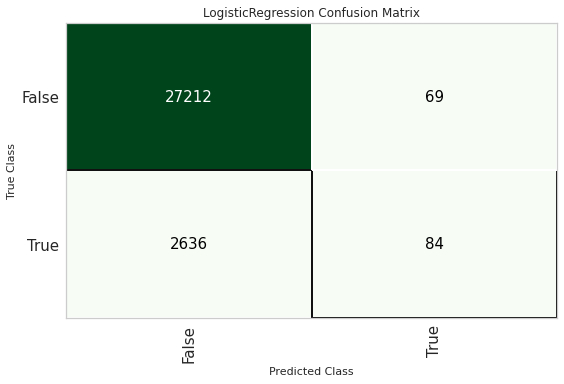

In [25]:
for model in top5:
    plot_model(model, 'confusion_matrix' )
    plt.show()

In [ ]:
Sacar los created at